In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [6]:
class MACD_Signal:
    def __init__(self, fast_period=12, slow_period=26, signal_period=9):
        self.fast_period=fast_period
        self.slow_period=slow_period
        self.signal_period=signal_period
    def __call__(self,data):
        fast_period=self.fast_period
        slow_period=self.slow_period
        signal_period=self.signal_period
        
        Close = data['Adj Close'].reset_index(drop=True)
        End = len(Close)
        EMA_fast = Close.ewm(span=fast_period, adjust=False).mean()
        EMA_slow = Close.ewm(span=slow_period, adjust=False).mean()
        MACD = EMA_fast - EMA_slow
        signal = MACD.ewm(span=signal_period, adjust=False).mean()
        if MACD[End-1] > signal[End-1]:
            if MACD[End-2] <= signal[End-2]:
                s = 1
            else:
                s = 0
        elif MACD[End-1] < signal[End-1]:
            if MACD[End-2] >= signal[End-2]:
                s = -1
            else:
                s=0
        else:
            s = 0

        return s

In [10]:
# Backtester assumes no commissions or slippage
# Takes in a MACD_signal object and historical pricing data

def backtest_MACD(MACD_signal, data):
    
    # Initialize variables for tracking trade status and profit/loss
    rlzPL = []
    pos = []
    t = []
    inpos = 0
    entry = 0

    # Loop through the historical stock data
    n = MACD_signal.slow_period
    for i in range(n+2,len(data)):
        MACD_s = MACD_signal(data[i-n-2:i])
        pos.append(inpos)
        
        # Buy signal
        if MACD_s == 1 and inpos != 1:
            if inpos == -1:
                rlzPL.append(entry-data["Adj Close"][i])
                t.append(i)
            
            entry = data["Adj Close"][i]
            inpos = 1
            
        # Sell signal
        elif MACD_s == -1 and inpos != -1:
            if inpos == 1:
                rlzPL.append(data["Adj Close"][i]-entry)
                t.append(i)
            entry = data["Adj Close"][i]
            inpos = -1
            
        else:
            pass

    return np.array(rlzPL), np.array(t), np.array(pos)


In [11]:
data = pd.read_csv("BTC-USD.csv")

In [25]:
data = yf.Ticker('BTC-USD').history(interval='1h', start='2021-04-18', end='2023-04-16')[["Close"]]
data = df.rename(columns={"Close":"Adj Close"})

In [26]:
MACD = MACD_Signal()
PL, t, pos = backtest_MACD(MACD, data)
unrlzPL = np.cumsum(np.multiply(np.diff(data["Adj Close"])[MACD.slow_period+2:],pos[1:]))

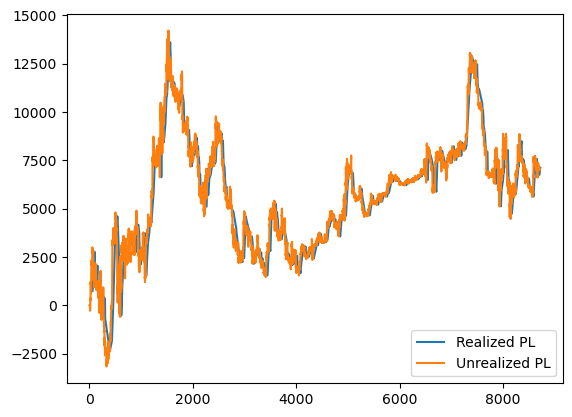

In [27]:
plt.plot(t, np.cumsum(PL), label="Realized PL")
plt.plot(unrlzPL, label="Unrealized PL")
plt.legend()
plt.show()

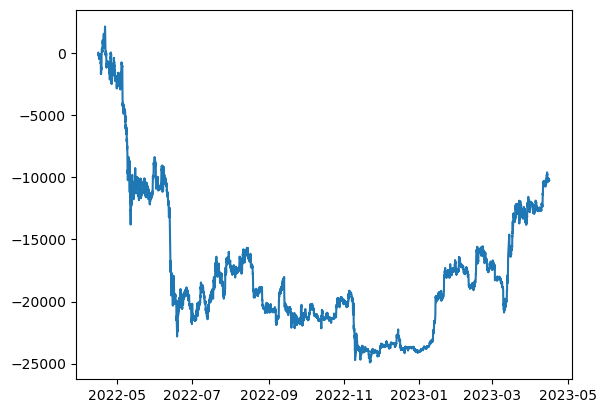

In [39]:
plt.plot(np.cumsum(data["Adj Close"].diff()))